<a href="https://colab.research.google.com/github/adubowski/redi-xai/blob/main/compare_distributions_numeric.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Compare the distributions of predictions numerically
This notebook contains code to quantify the extent that class predictions (benign/malignant) change when we alter the images by: 1) inpainting random sections of control images, 2) inpainting (thus removing) coloured patches, and 3) artificially inserting coloured patches into images of malignant lesions.

### Initialise Libraries & Paths

In [ ]:
import numpy as np
from google.colab import drive
import os
from os.path import join as oj
from datetime import datetime

from scipy.spatial import distance
from scipy.stats import wasserstein_distance, entropy
from sklearn import metrics
import warnings

import matplotlib
from matplotlib import pyplot as plt
plt.style.use('seaborn')

In [ ]:
drive.mount("/content/drive")
dir_path = "/content/drive/MyDrive/redi-detecting-cheating"
data_path = oj(dir_path, "data")

test_path  = oj(dir_path, "models", "test_files_used.txt")

patch_run_name = "test_20210608-083437_inpaint_coloured_patches_gmcnn_s224x224_gc32"
no_patch_run_name = "test_20210608-083438_inpaint_no_patches_gmcnn_s224x224_gc32_randmask-ellipse_seed-1"

Mounted at /content/drive


### Load Predictions & Indices
The probability output of the classifier for each image in the test set has been saved previously under each of the experimental conditions. Load these from file.

In [ ]:
targets_test_unaltered, preds_test_unaltered  = np.load(oj(data_path, 'saved-tensors', 'preds_test_unaltered.npz')).values()
_, preds_inpainted_patches =    np.load(oj(data_path, 'saved-tensors', 'preds_inpainted_patches.npz')).values()
_, preds_inpainted_no_patches = np.load(oj(data_path, 'saved-tensors', 'preds_inpainted_no_patches.npz')).values()
_, preds_malignant_patches = np.load(oj(data_path, 'saved-tensors', 'preds_malignant_patches.npz')).values()

# Load the output predictions from the classifier retrained on inpainted examples.
_, preds_test_unaltered_v2  = np.load(oj(data_path, 'saved-tensors', 'preds_test_unaltered_v2.npz')).values()
_, preds_inpainted_patches_v2 =    np.load(oj(data_path, 'saved-tensors', 'preds_inpainted_patches_v2.npz')).values()
_, preds_inpainted_no_patches_v2 = np.load(oj(data_path, 'saved-tensors', 'preds_inpainted_no_patches_v2.npz')).values()
_, preds_malignant_patches_v2 = np.load(oj(data_path, 'saved-tensors', 'preds_malignant_patches_v2.npz')).values()

In [ ]:
test_path_patches     = oj(dir_path, "data", "test", patch_run_name, "inpainted")
test_path_no_patches  = oj(dir_path, "data", "test", no_patch_run_name, "inpainted")

path_malignant_patches = oj(dir_path, "data", "malignant-patches", "manually-adjusted")

##### Get lists of filenames in the whole test set and in the experimental subsets.

In [ ]:
# List of all files in the test set used to get predictions from the models.
test_fpaths = open(test_path, 'rt').read().splitlines()
test_files = [os.path.basename(file) for file in test_fpaths] # Extract the filename from the full filepath.
test_files = sorted(test_files) # Order by file name (image number)

def sort_filenames(dataset_path):
  return sorted(os.listdir(dataset_path))

patch_files = sort_filenames(test_path_patches)
no_patch_files = sort_filenames(test_path_no_patches)
malignant_patch_files = sort_filenames(path_malignant_patches)
malignant_patch_files = [f + '.jpg' for f in 
                         np.unique([fname[:12] for fname in malignant_patch_files])]

##### Find the indices of the whole test set which correspond to the files of the experimental subsets.

In [ ]:
patch_ind = [file in patch_files for file in test_files]   # Get a boolean list of whether the test file has a patch.
no_patch_ind = [file in no_patch_files for file in test_files]
# Get a list indices for the relevant malignant files.
mal_idx = [i for f1 in malignant_patch_files  
              for i,f2 in enumerate(test_files) 
                if f1 == f2]

### Compare Binned Distributions
First bin the predicted probabilities into histograms with 10 bins (as in the visualisations). Then use Jensen-Shannon distance, Euclidean distance and Wasserstein Distance to compare the distributions.

In [ ]:
def euclid_normalised(hist1, hist2):
  h1 = hist1/sum(hist1)
  h2 = hist2/sum(hist2)
  return distance.euclidean(h1, h2)

def compare_histograms(probs_unaltered, probs_altered, exp_id='', bins=10):
  hist1,_ = np.histogram(probs_unaltered, bins=bins, range = (0,1))
  hist2,_ = np.histogram(probs_altered, bins=bins, range = (0,1))

  bin_loc = np.linspace(0, 1, bins)

  js = distance.jensenshannon(hist1, hist2, base=2)
  ed = euclid_normalised(hist1, hist2)
  wd = wasserstein_distance(bin_loc, bin_loc, hist1, hist2)

  dist_dict = {
      'Euclidean (Bins) | ' + exp_id:       ed,
      'Jensen-Shannon (Bins) | ' + exp_id:  js,
      'Wasserstein (Bins) | ' + exp_id:     wd
  }
  return dist_dict

### Compare Individual Predictions
Use the probability estimates for each image to compare between the altered & unaltered versions and then aggregate to get an overall assessment of the change. Using Euclidean distance, Manhattan distance, Mean Absolute Deviation, Root Mean Square Deviation, Mean Jenson-Shannon distance, and Mean KL Divergence.

In [ ]:
""" All of the following functions expect two numpy arrays of equal length containing probabilities to compare."""

def js_distance(probs_unaltered, probs_altered):
  # The probability distributions to compare are [p_malignant, p_benign] for the unaltered images vs. the altered images.
  P = np.array([probs_unaltered, 1-probs_unaltered])
  Q = np.array([probs_altered, 1-probs_altered])

  # Calculate JS distance. Base 2 is used since it is bounded by 1 and easier to interpret.
  js = distance.jensenshannon(P, Q, base=2) 
  # Occasionally NAN values arise from the JS function if the probabilities being compared are very similar.
  # Set these NAN values to 0 when the original probabilities are close enough.
  js[np.isnan(js) & (abs(probs_unaltered-probs_altered) < 0.0005)] = 0.0

  if np.sum(np.isnan(js)) > 0: 
    warnings.warn('NAN values remaining in the Jensen-Shannon vector.')

  return js

def kl_divergence(probs_baseline, probs_comparison):
  P = np.array([probs_baseline, 1-probs_baseline])
  Q = np.array([probs_comparison, 1-probs_comparison])

  return entropy(P, Q, base=2)

def calc_signed_distances(probs_unaltered, probs_altered):
  distance = probs_altered - probs_unaltered
  neg_distance = distance[distance < 0]
  pos_distance = distance[distance >= 0]
  return len(pos_distance), np.mean(pos_distance), len(neg_distance), np.mean(neg_distance)

def calc_portion_crossed_bound(probs_unaltered, probs_altered, dec_bound = 0.4):
  crossed_bound = sum((probs_altered >= dec_bound) & (probs_unaltered < dec_bound))
  return crossed_bound, crossed_bound / len(probs_unaltered)

def compare_probabilities(probs_unaltered, probs_altered, exp_id=''):
  if len(probs_unaltered) != len(probs_altered):
    raise ValueError("Prob vectors are not the same length!")
  euclid = distance.euclidean(probs_unaltered, probs_altered)
  manhat = distance.cityblock(probs_unaltered, probs_altered)
  mae = metrics.mean_absolute_error(probs_unaltered, probs_altered)
  n_pos, mean_pos, n_neg, mean_neg = calc_signed_distances(probs_unaltered, probs_altered)
  mse = metrics.mean_squared_error(probs_unaltered, probs_altered)
  rmse = np.sqrt(mse)
  mjs = np.mean(js_distance(probs_unaltered, probs_altered))
  mkl = np.mean(kl_divergence(probs_unaltered, probs_altered))
  crossed_bound_pos, crossed_bound_rate_pos = calc_portion_crossed_bound(probs_unaltered, probs_altered)
  crossed_bound_neg, crossed_bound_rate_neg = calc_portion_crossed_bound(probs_altered, probs_unaltered)
  dist_dict = {
      'Vector length | ' + exp_id: len(probs_unaltered),
      'Euclidean Vector | ' + exp_id: euclid,
      'Manhattan Vector | ' + exp_id: manhat,
      'Mean Absolute Deviation | ' + exp_id: mae,
      'Mean Square Deviation | ' + exp_id: mse,
      'N Positive Distance | ' + exp_id: n_pos,
      'Mean Positive Distance | ' + exp_id: mean_pos,
      'N Negative Distance | ' + exp_id: n_neg,
      'Mean Negative Distance | ' + exp_id: mean_neg,
      'Crossed Bound Positive | ' + exp_id: crossed_bound_pos,
      'Crossed Bound Rate Positive | ' + exp_id: crossed_bound_rate_pos,
      'Crossed Bound Negative | ' + exp_id: crossed_bound_neg,
      'Crossed Bound Rate Negative | ' + exp_id: crossed_bound_rate_neg,
      'Root Mean Square Deviation | ' + exp_id: rmse,
      'Mean Jensen-Shannon Distance | ' + exp_id: mjs
      # 'Mean KL Divergence | ' + exp_id: mkl
  }
  return dist_dict

### Run all comparisons

In [ ]:
def compare_distributions(probs_unaltered, probs_altered, exp_id=''):
  """ Expects two numpy arrays (vectors) of equal length containing probabilities to compare.
  Returns a dict where the keys are the names of the statistics, and the values are the computed values. 
  exp_id is an optional string to append to the keys of the returned dictionary.  
  """
  hist_distances = compare_histograms(probs_unaltered, probs_altered, exp_id=exp_id, bins=10)
  prob_distances = compare_probabilities(probs_unaltered, probs_altered, exp_id=exp_id)

  return {**hist_distances, **prob_distances}

##### Run the comparison for each of the experiments and save the results to one master dictionary.

In [ ]:
dist_np = compare_distributions(preds_test_unaltered[no_patch_ind], preds_inpainted_no_patches, exp_id='No Patches')
dist_np_v2 = compare_distributions(preds_test_unaltered_v2[no_patch_ind], preds_inpainted_no_patches_v2, exp_id='No Patches (Retrained)')
dist_p = compare_distributions(preds_test_unaltered[patch_ind], preds_inpainted_patches, exp_id='Inpainted Patches')
dist_p_v2 = compare_distributions(preds_test_unaltered_v2[patch_ind], preds_inpainted_patches_v2, exp_id='Inpainted Patches (Retrained)')
dist_mp = compare_distributions(preds_test_unaltered[mal_idx], preds_malignant_patches, exp_id='Malignant Inserted Patches')
dist_mp_v2 = compare_distributions(preds_test_unaltered_v2[mal_idx], preds_malignant_patches_v2, exp_id='Malignant Inserted Patches (Retrained)')

distances = {**dist_np, **dist_np_v2, **dist_p, **dist_p_v2, **dist_mp, **dist_mp_v2}

/usr/local/lib/python3.7/dist-packages/scipy/spatial/distance.py:1296: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(js / 2.0)
/usr/local/lib/python3.7/dist-packages/scipy/spatial/distance.py:1296: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(js / 2.0)


#####Write to file

In [ ]:
results_file = oj(dir_path, 'models', 'distances_' + datetime.now().strftime('%Y%m%d%H%M%S') + '.txt')
with open(results_file, 'w') as file:
    for k,v in distances.items():
      file.write(k + ":" + str(v) + "\n")

### Complementary Plots
Plot boxplots for the absolute change in probability, kl divergence, jensen shannon distance.

In [ ]:
def plot_boxplots(axes, probs_baseline, probs_comparison, pos, label):
  abs_dev = abs(probs_baseline - probs_comparison)
  js = js_distance(probs_baseline, probs_comparison)
  kl = kl_divergence(probs_baseline, probs_comparison)

  axes[0].boxplot(abs_dev, positions = [pos], labels=[label])
  axes[1].boxplot(js, positions = [pos], labels=[label])
  axes[2].boxplot(kl, positions = [pos], labels=[label])

  axes[0].set_ylabel('Absolute Deviation', fontsize=14)
  axes[1].set_ylabel('JS Distance', fontsize=14)
  axes[2].set_ylabel('KL Divergence', fontsize=14)

/usr/local/lib/python3.7/dist-packages/scipy/spatial/distance.py:1296: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(js / 2.0)
/usr/local/lib/python3.7/dist-packages/scipy/spatial/distance.py:1296: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(js / 2.0)


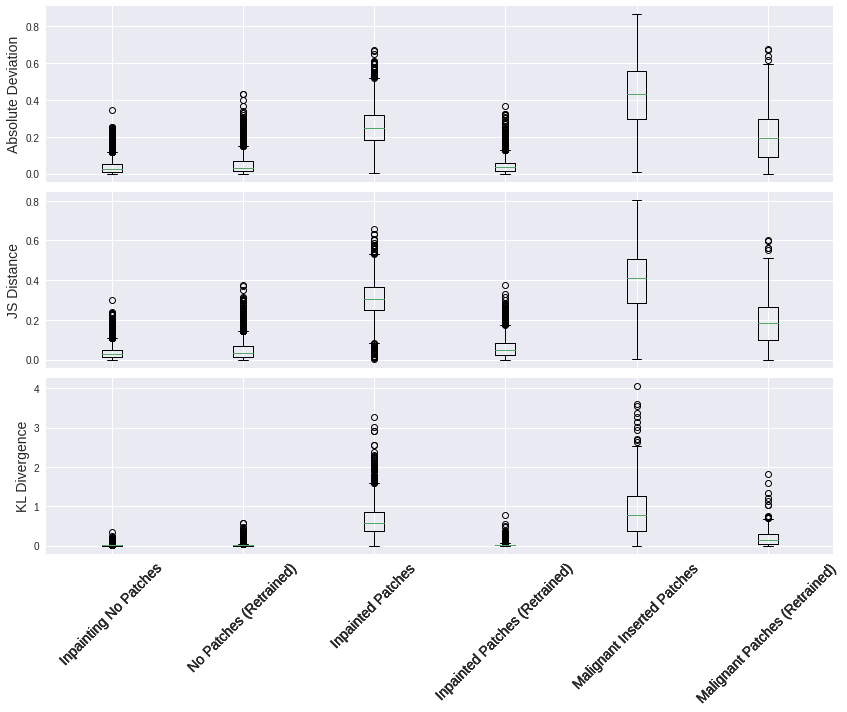

In [ ]:
fig, axes = plt.subplots(3, 1, figsize = (12,10), sharex=True)

plot_boxplots(axes, preds_test_unaltered[no_patch_ind], preds_inpainted_no_patches, 0, label = 'Inpainting No Patches')
plot_boxplots(axes, preds_test_unaltered_v2[no_patch_ind], preds_inpainted_no_patches_v2, 1, label = 'No Patches (Retrained)')
plot_boxplots(axes, preds_inpainted_patches, preds_test_unaltered[patch_ind], 2, label = 'Inpainted Patches')
plot_boxplots(axes, preds_inpainted_patches_v2, preds_test_unaltered_v2[patch_ind], 3, label = 'Inpainted Patches (Retrained)')
plot_boxplots(axes, preds_test_unaltered[mal_idx], preds_malignant_patches, 4, label = 'Malignant Inserted Patches')
plot_boxplots(axes, preds_test_unaltered_v2[mal_idx], preds_malignant_patches_v2, 5, label = 'Malignant Patches (Retrained)')

axes[2].tick_params(axis='x', rotation=45, labelsize=14)
plt.tight_layout()